# MCMC

### import package

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from numpy import array,sqrt,cos,sin,abs
from numpy.linalg import inv
from numpy.random import random

from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline

from lib.Model import Analytical_Model

Model = lambda t, params, m, xi, vi:Analytical_Model(t, k=params, m=m, x1_i=xi[0], x2_i=xi[1], v1_i=vi[0], v2_i=vi[1])

In [2]:
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
    "figure.dpi": 200,
    "figure.figsize": (12,5),
    "lines.linewidth": 1,
    "lines.markersize": 3
})

In [3]:
# 顯示所有 csv 檔案
!ls data

2023-6-12-20-53.csv 2023-6-12-22-3.csv  2023-6-13-11-11.csv 2023-6-13-12-1.csv
2023-6-12-21-0.csv  2023-6-12-22-37.csv 2023-6-13-11-9.csv  2023-6-13-12-2.csv
2023-6-12-21-10.csv 2023-6-13-11-10.csv 2023-6-13-12-0.csv


### Read CSV data

In [6]:
# 讀取資料
name = "2023-6-12-22-3"

directory = f"result/{name}"
if not os.path.exists(directory):
    os.makedirs(directory)
    
data = pd.read_csv(f"./data/{name}.csv", header=None) 

# 楚存資料
time_sec_ = data[0].to_numpy()  # (sec)
x1_laser_ = data[1].to_numpy() *  0.01 # (cm -> m)
x2_laser_ = data[2].to_numpy() * -0.01 # (cm -> m)
x1_sound_ = data[3].to_numpy() *  0.01 # (cm -> m)
x2_sound_ = data[4].to_numpy() * -0.01 # (cm -> m)

x1_laser_ = x1_laser_ - np.mean(x1_laser_)
x2_laser_ = x2_laser_ - np.mean(x2_laser_)
x1_sound_ = x1_sound_ - np.mean(x1_sound_)
x2_sound_ = x2_sound_ - np.mean(x2_sound_)

# 時間平移，第一項為 0 
time_sec_ = time_sec_ - time_sec_[0]


# 數據平滑
win_size = 5
x1 = savgol_filter(x1_sound_, win_size, 3)
x2 = savgol_filter(x2_sound_, win_size, 3)

# 數據差值
x1_spline = CubicSpline(time_sec_, x1)
x2_spline = CubicSpline(time_sec_, x2)

### Plot original data ( not shifted )

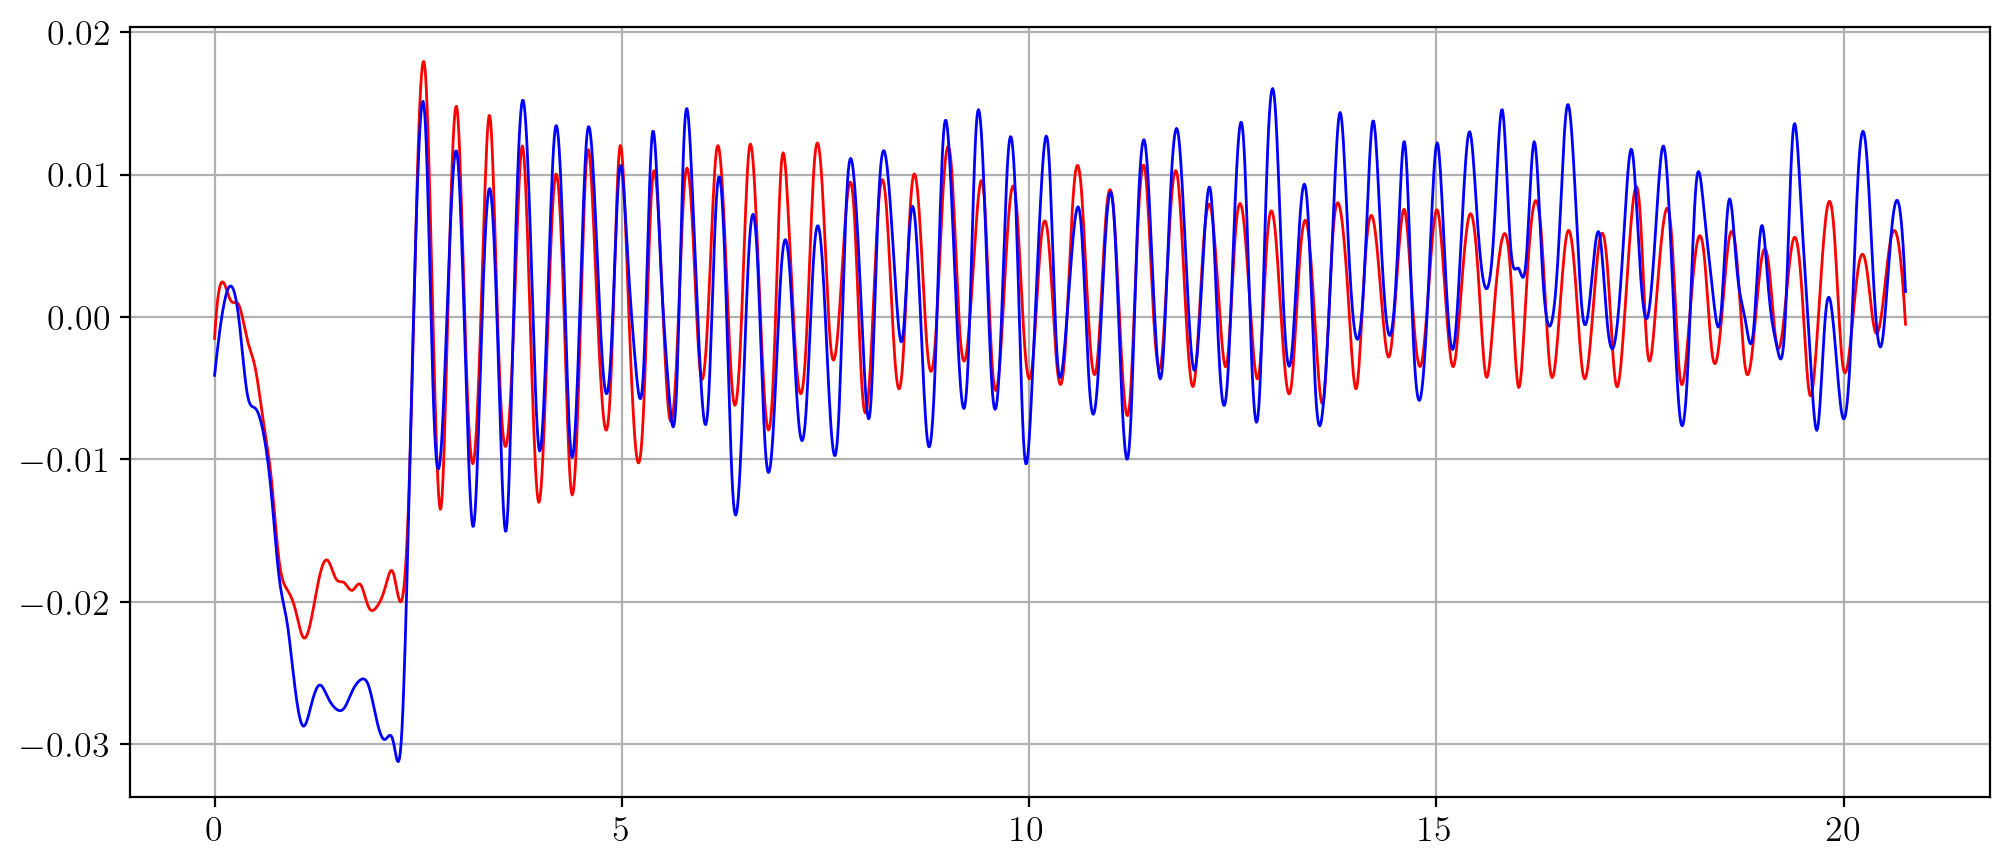

In [7]:
t = np.arange(0,max(time_sec_),0.01)
plt.figure()
plt.plot(t,x1_spline(t),'-',color='red')
plt.plot(t,x2_spline(t),'-',color='blue')
plt.grid()
plt.show()

# Plot data near start time

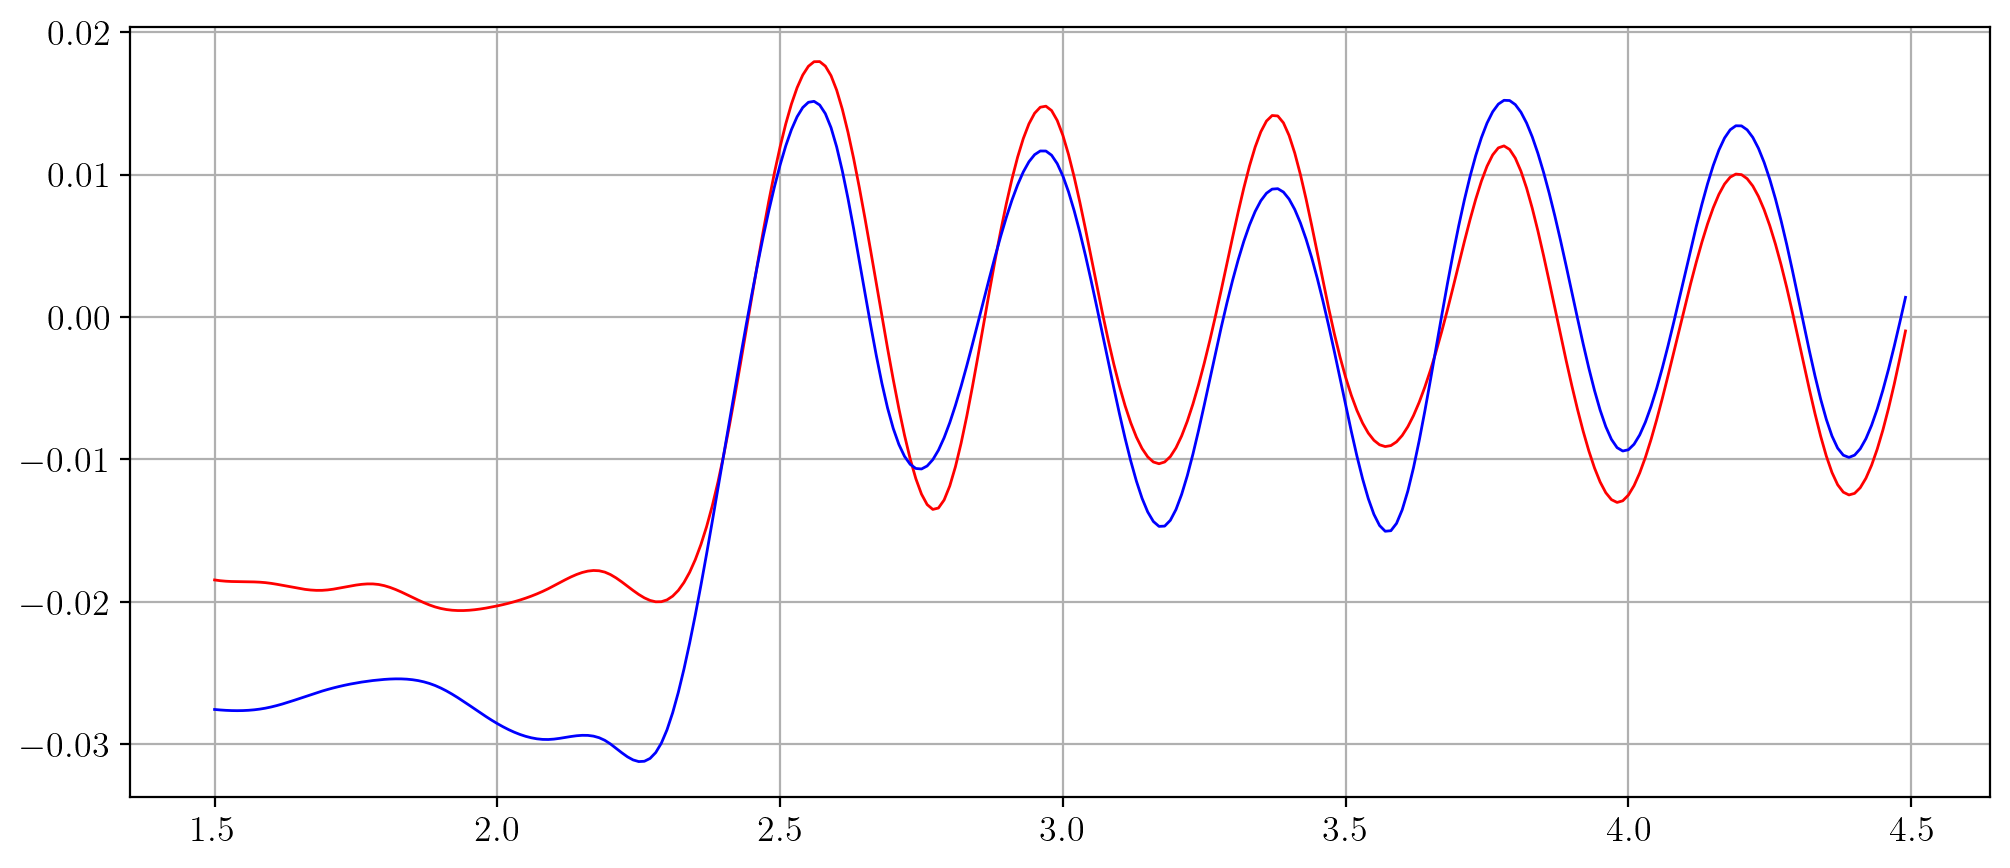

In [9]:
t_min = 1.5
t_max = 4.5
t = np.arange(t_min,t_max,0.01)
plt.plot(t,x1_spline(t),'-',color='red')
plt.plot(t,x2_spline(t),'-',color='blue')
plt.grid()
plt.show()

choose $t_0$

In [10]:
t0 = 2.5

t0_index = np.argmax(time_sec_ > t0)

time_sec = time_sec_[t0_index:]
x1_laser = x1_laser_[t0_index:]
x2_laser = x2_laser_[t0_index:]
x1_sound = x1_sound_[t0_index:]
x2_sound = x2_sound_[t0_index:]

# 時間平移，第一項為 0 
time_sec = time_sec - time_sec[0]

# 數據平滑
win_size = 5
x1 = savgol_filter(x1_sound, win_size, 3)
x2 = savgol_filter(x2_sound, win_size, 3)

# 數據差值
x1_spline = CubicSpline(time_sec, x1)
x2_spline = CubicSpline(time_sec, x2)
v1_spline = x1_spline.derivative()
v2_spline = x2_spline.derivative()

### plot shifted data

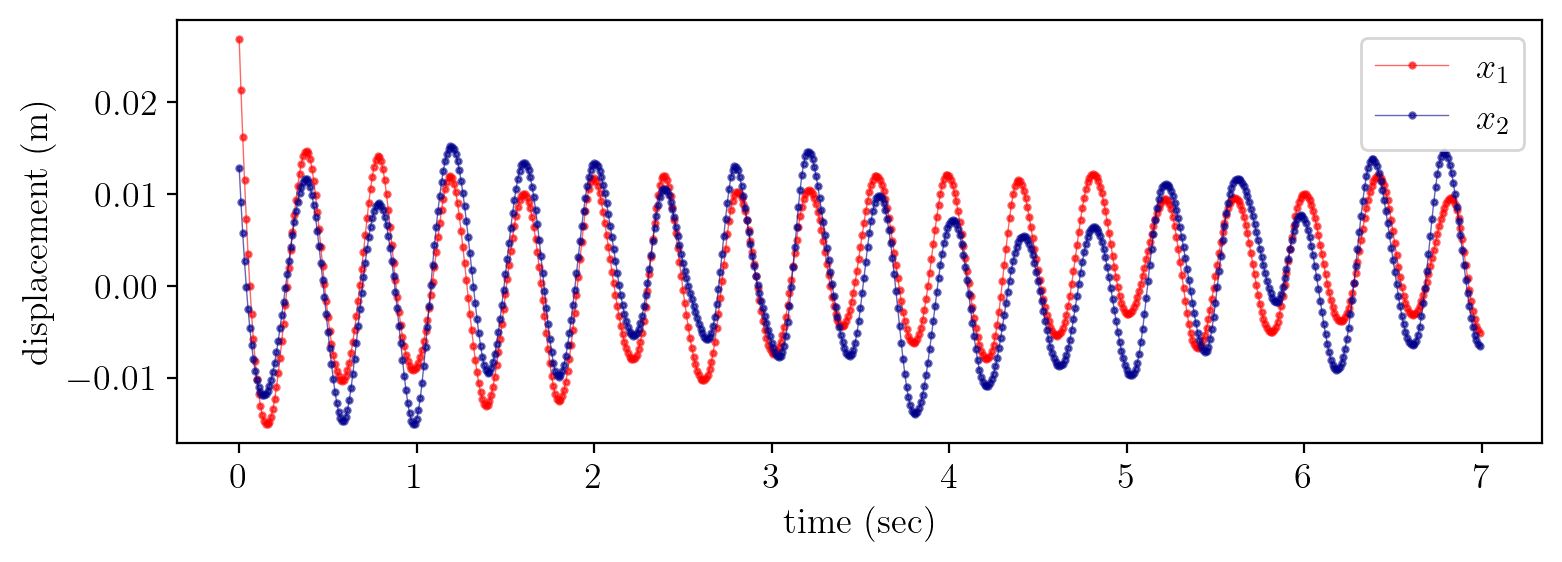

In [12]:
fig1 = plt.figure(figsize=(8,3))

t_end = time_sec[-1]
t = np.arange(0, 7, 0.01)
plt.plot(t,x1_spline(t),'-o', color='red',alpha=0.6,label="$x_1$",markersize=2,linewidth=0.5)
plt.plot(t,x2_spline(t),'-o',color='darkblue',alpha=0.6,label="$x_2$",markersize=2,linewidth=0.5)
plt.ylabel("displacement (m)")
plt.xlabel("time (sec)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### MCMC

In [518]:
def constrain(x, a, b):
    return 0.5*(np.tanh(10*(x-a)) + np.tanh(10*(b-x)))

def P_MSE(t, k, x1_data, x2_data, m, xi, vi):
    N = len(t)
    
#     if(k[0]<0): return np.exp(k[0])*1e-8
#     if(k[1]<0): return np.exp(k[1])*1e-8
#     if(k[2]<0): return np.exp(k[2])*1e-8
    
#     if(any(np.array(k)<0)): return 0
    
    x1_theo, x2_theo, v1_theo ,v2_theo = Model(t, k, m, xi, vi)
    MSE1 = np.sum((x1_data - x1_theo)**2) / N
    MSE2 = np.sum((x2_data - x2_theo)**2) / N
    P = np.exp(-(MSE1+MSE2))
    return np.exp(20000*(P-1)) #* constrain(np.array(k).mean(), 0, 100)

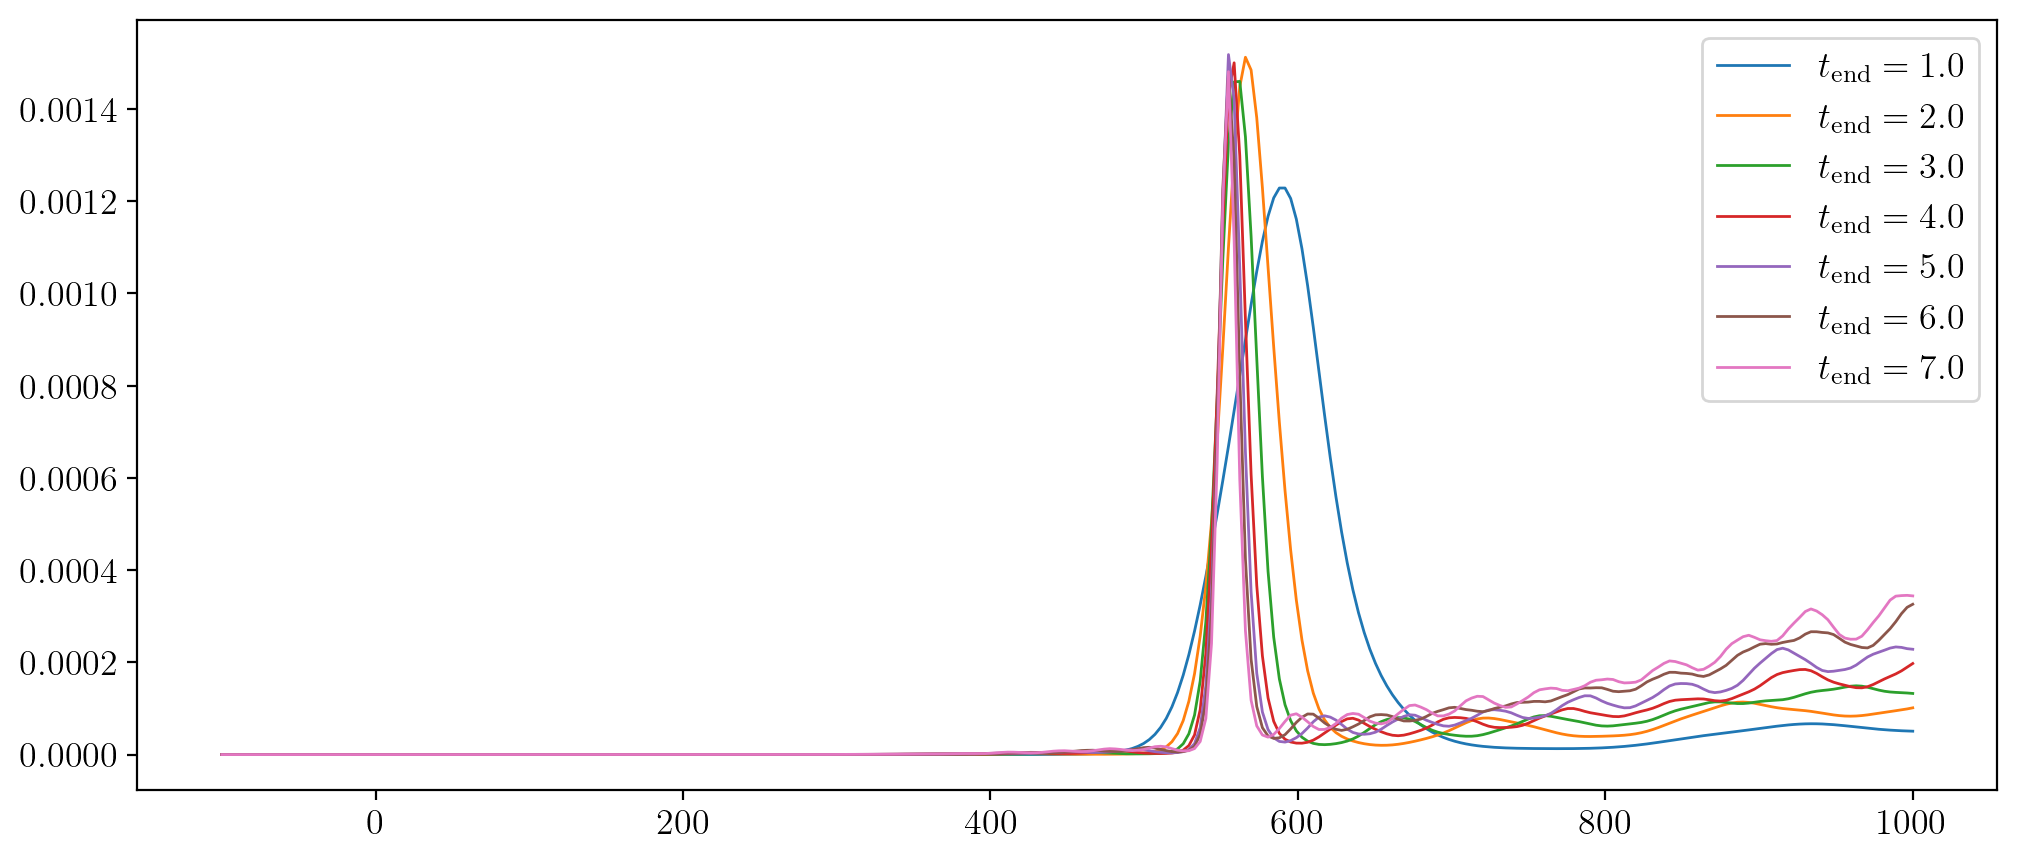

In [519]:
plt.figure(figsize=(12,5))

for t_end in [1,2,3,4,5,6,7]:
    m = (0.7216, 0.6950)
    xi = (x1_spline(0), x2_spline(0))
    vi = (v1_spline(0), v2_spline(0))

    t = np.arange(0, t_end, 0.01)
    x1_data = x1_spline(t)
    x2_data = x1_spline(t)

    K = np.linspace(-100, 1000, 300)
    Prob = np.zeros(len(K))

    for i in range(len(K)):
        k = K[i]
        prob  = P_MSE(t, (k, k, k), x1_data, x2_data, m, xi, vi)
        Prob[i] = prob
    plt.plot(K, Prob, label=r"$t_{\rm end}=%.1f$"%t_end)

plt.legend()
plt.show()

In [535]:
t_end = 4
m = (0.7216, 0.6950)
xi = (x1_spline(0), x2_spline(0))
vi = (v1_spline(0), v2_spline(0))

t = np.arange(0, t_end, 0.01)
x1_data = x1_spline(t)
x2_data = x1_spline(t)

N = 20000
delta = 10.0
Paras = np.zeros([N, 3])
paras = 100 + 100 * random(3)
acc_n = 0
# --------------------------------------------------
# Thermal equilibrium
print(paras)
for i in range(1000):
    paras_ = paras + delta * (2.0*random(3)-1.0)
    p  = P_MSE(t, paras, x1_data, x2_data, m, xi, vi)
    p_  = P_MSE(t, paras_, x1_data, x2_data, m, xi, vi)
    if(p_ >= p or random() < p_/p): 
        paras = paras_
        acc_n += 1
acc_rate = acc_n/1000
print(r"acceptance rate : %.5f"%acc_rate)
# --------------------------------------------------
# MCMC record
print(paras)
acc_n = 0
for i in range(N):
    paras_ = paras + delta * (2.0*random(3)-1.0)
    p  = P_MSE(t, paras, x1_data, x2_data, m, xi, vi)
    p_  = P_MSE(t, paras_, x1_data, x2_data, m, xi, vi)
    if(p_ >= p or random() < p_/p): 
        paras = paras_
        acc_n += 1
    Paras[i] = paras

acc_rate = acc_n/N
print(r"acceptance rate : %.5f"%acc_rate)

[115.43408542 198.37561022 143.95302417]
acceptance rate : 0.88900
[266.05521493 543.42810885 101.42911067]
acceptance rate : 0.94765


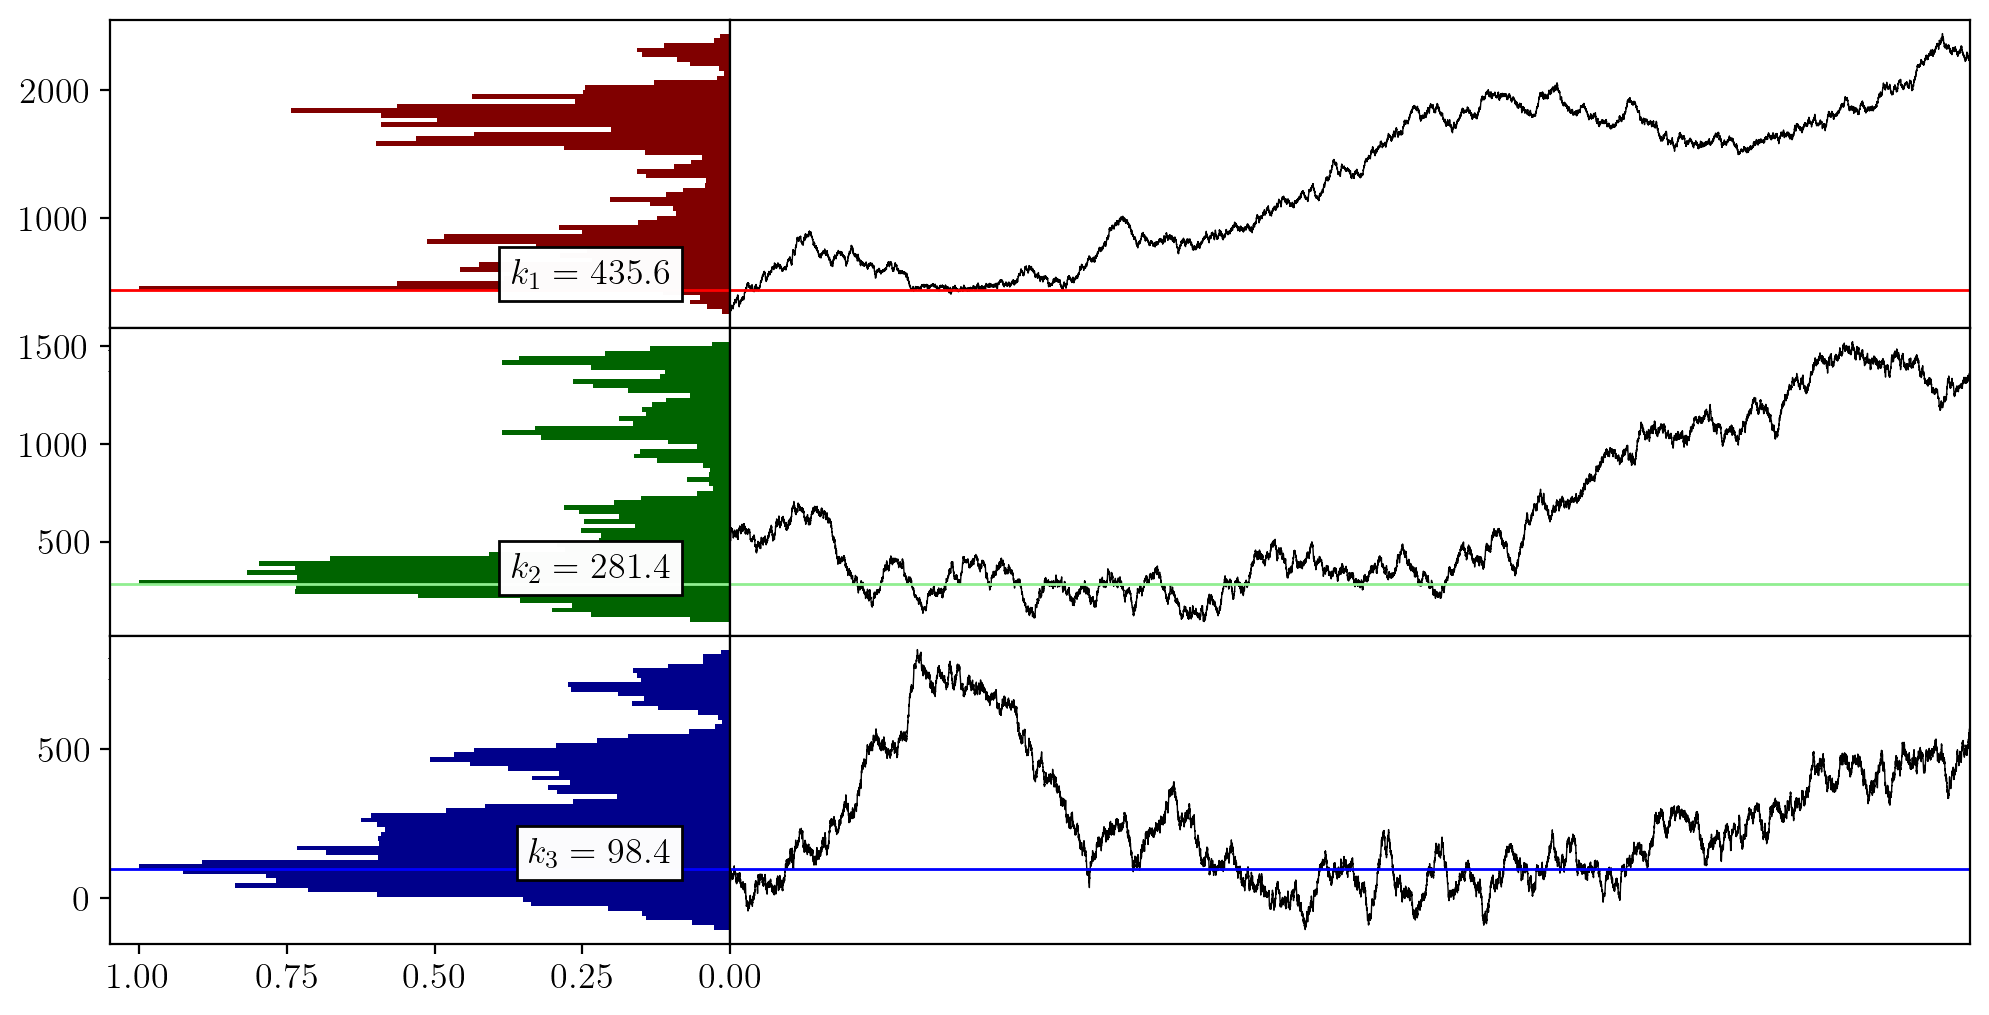

In [536]:
bins = 60

K1,K2,K3 = (Paras[:,0], Paras[:,1], Paras[:,2])
fig = plt.figure(figsize=(12,6), dpi=200)
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=1)
ax4 = plt.subplot2grid((3, 3), (1, 1), colspan=2)
ax5 = plt.subplot2grid((3, 3), (2, 0), colspan=1)
ax6 = plt.subplot2grid((3, 3), (2, 1), colspan=2)

counts1, bins1 = np.histogram(K1, bins=bins)
counts2, bins2 = np.histogram(K2, bins=bins)
counts3, bins3 = np.histogram(K3, bins=bins)

k1_max = bins1[np.argmax(counts1)]
k2_max = bins2[np.argmax(counts2)]
k3_max = bins3[np.argmax(counts3)]

ax1.hist(bins1[:-1], bins1, color="maroon",weights=counts1/counts1.max(), orientation='horizontal')
ax3.hist(bins2[:-1], bins2, color="darkgreen",weights=counts2/counts2.max(),orientation='horizontal')
ax5.hist(bins3[:-1], bins3, color="darkblue",weights=counts3/counts3.max(),orientation='horizontal')

ax2.plot(K1,color="k", linewidth=0.5,label=r"$\left({\rm step}, k_2\right)$")
ax4.plot(K2,color="k", linewidth=0.5,label=r"$\left({\rm step}, k_2\right)$")
ax6.plot(K3,color="k", linewidth=0.5,label=r"$\left({\rm step}, k_3\right)$")

[ax.axhline(k1_max, color="red", linewidth=1) for ax in [ax1, ax2]]
[ax.axhline(k2_max, color="lightgreen", linewidth=1) for ax in [ax3, ax4]]
[ax.axhline(k3_max, color="blue", linewidth=1) for ax in [ax5, ax6]]

[ax.invert_xaxis() for ax in [ax1,ax3,ax5]]
[ax.set_xticks([]) for ax in [ax2,ax4,ax6]]
[ax.set_yticks([]) for ax in [ax2,ax4,ax6]]

ax2.set_xlim(0,K1.size)
ax4.set_xlim(0,K2.size)
ax6.set_xlim(0,K3.size)

ax1.text(0.1, k1_max, r"$k_1 = %.1f$"%k1_max, 
         horizontalalignment="right", verticalalignment="bottom", bbox=dict(facecolor='white', alpha=0.99))
ax3.text(0.1, k2_max, r"$k_2 = %.1f$"%k2_max, 
         horizontalalignment="right", verticalalignment="bottom", bbox=dict(facecolor='white', alpha=0.99))
ax5.text(0.1, k3_max, r"$k_3 = %.1f$"%k3_max, 
         horizontalalignment="right", verticalalignment="bottom", bbox=dict(facecolor='white', alpha=0.99))

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Compare

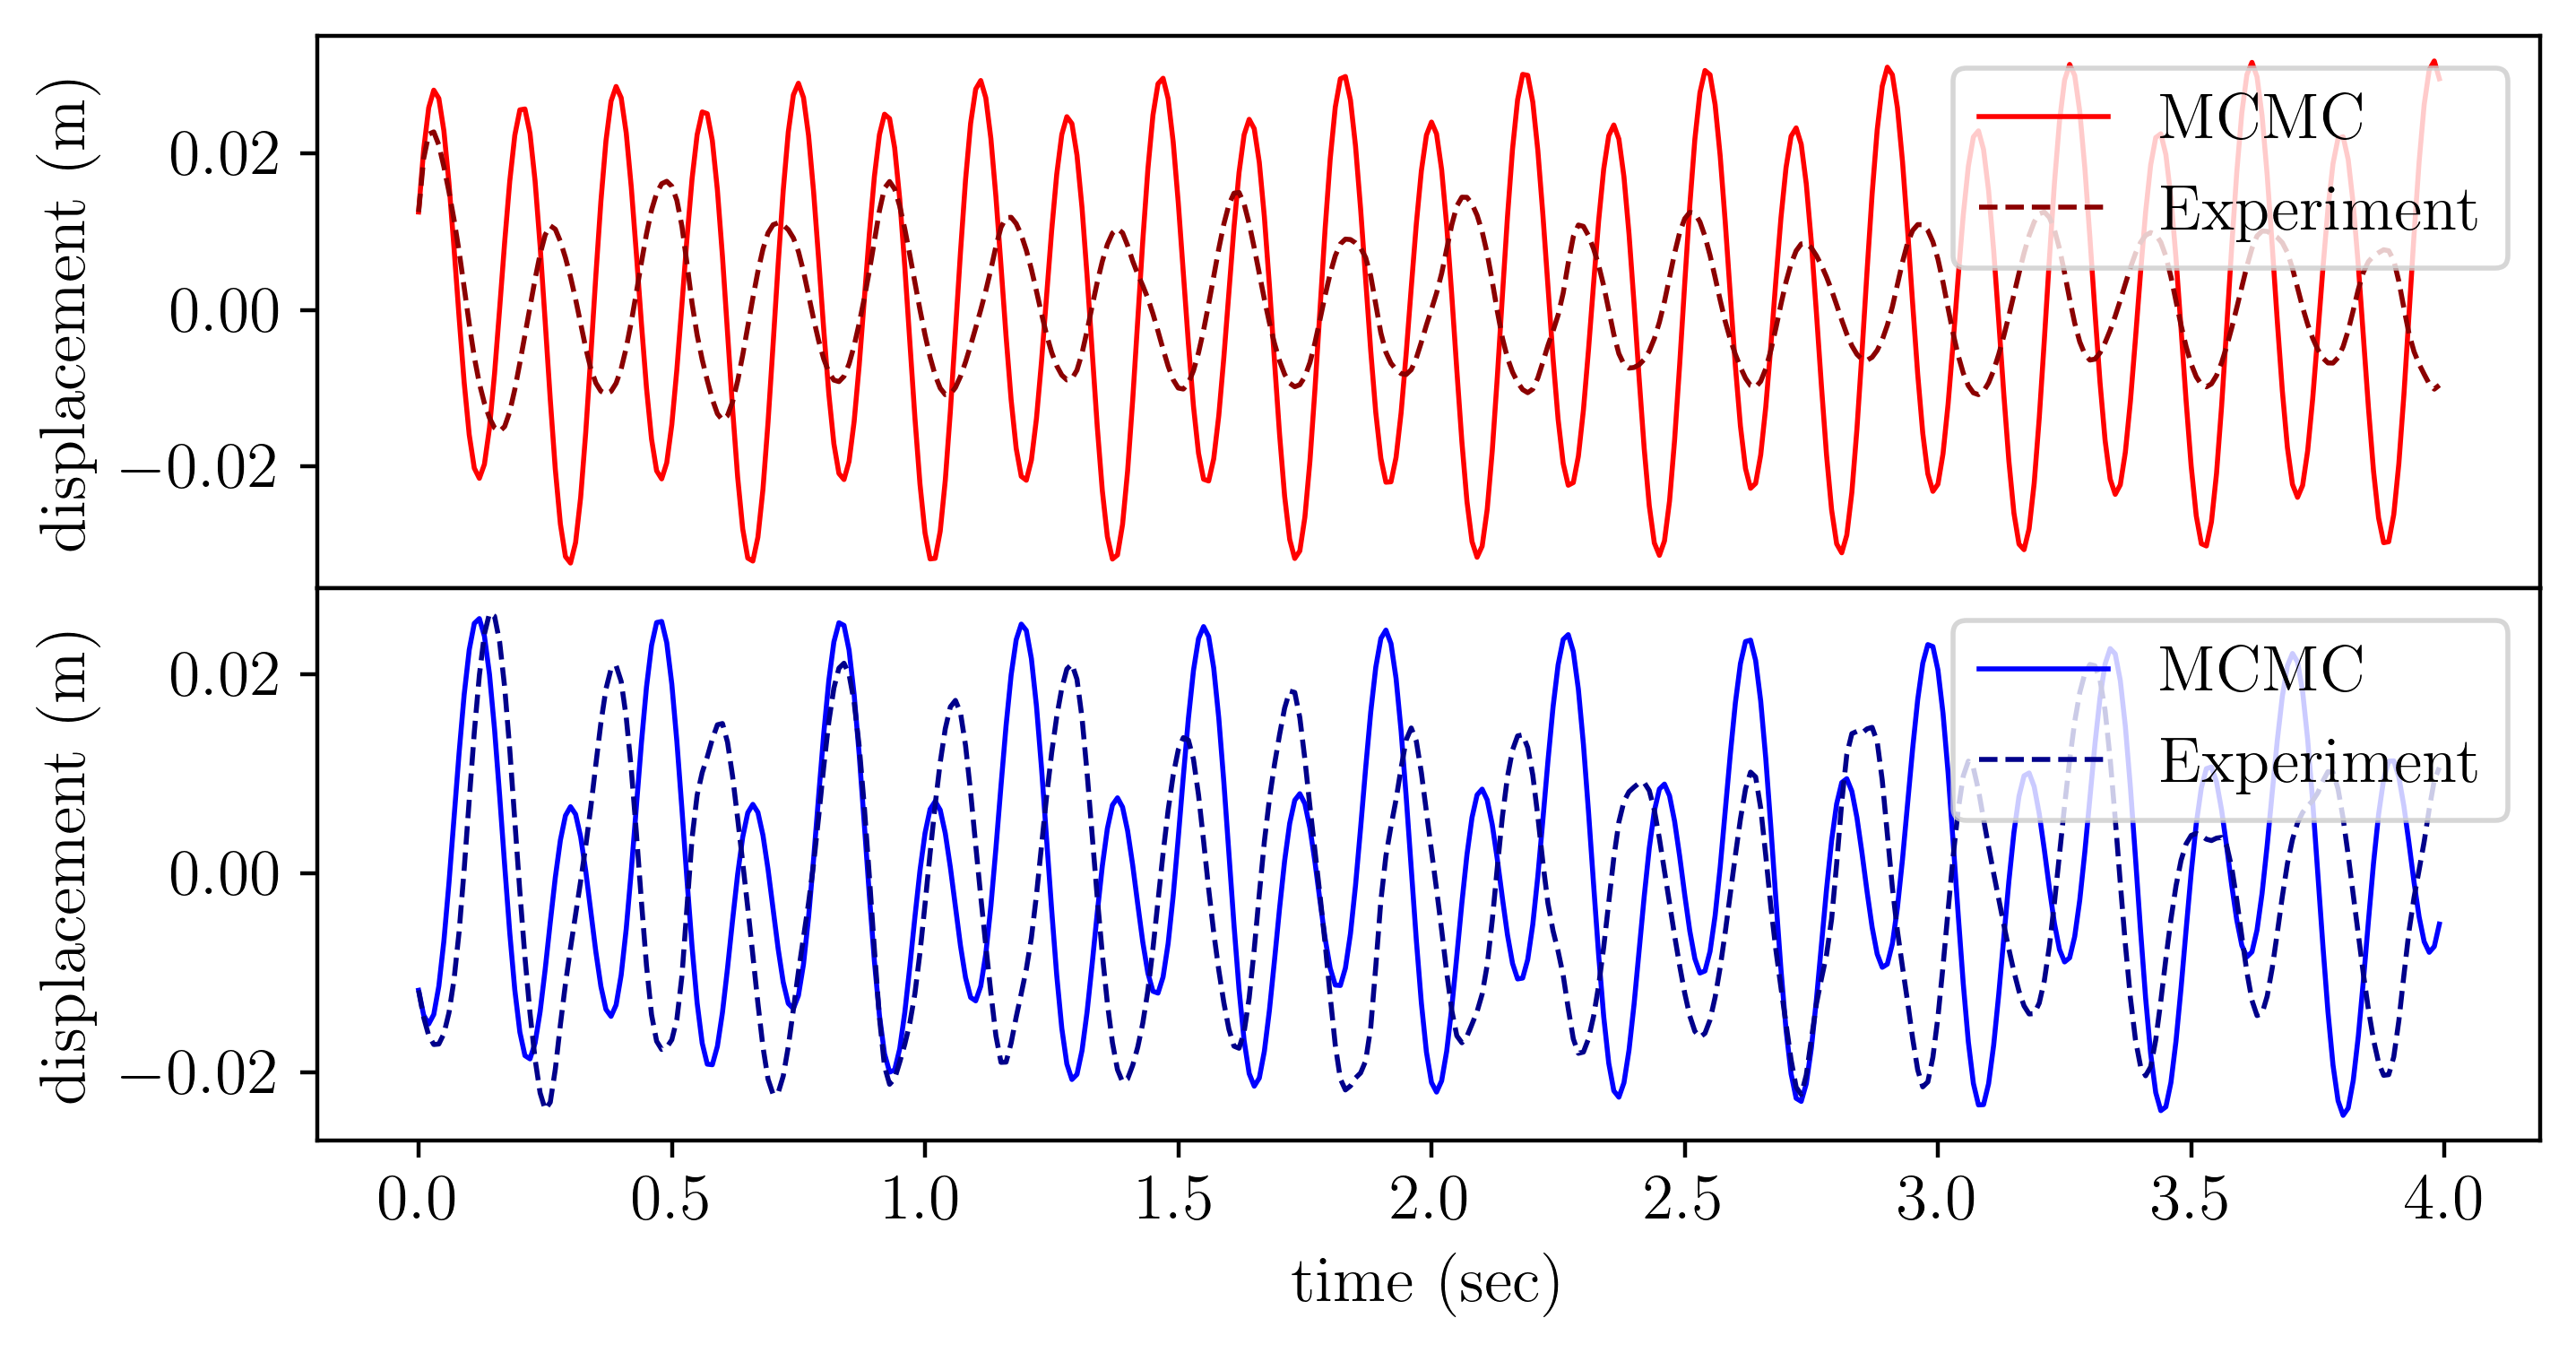

In [537]:
x1,x2,v1,v2 = Model(t, (k1_max, k2_max, k3_max), m, xi, vi)

fig3 = plt.figure(figsize=(8,4), dpi=400)
plt.subplot(2,1,1)
plt.plot(t,x1,color='red',label='MCMC',markersize=2)
plt.plot(t,x1_spline(t),'--',color='darkred',label='Experiment',markersize=2)
plt.legend(loc='upper right')
plt.ylabel("displacement (m)")
plt.xticks([])

plt.subplot(2,1,2)
plt.plot(t,x2,color='blue',label='MCMC',markersize=2)
plt.plot(t,x2_spline(t),'--',color='darkblue',label='Experiment',markersize=2)
plt.legend(loc='upper right')
plt.ylabel("displacement (m)")
plt.xlabel("time (sec)")

plt.subplots_adjust(hspace=0)
plt.show()